In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

## ARIMA and SARIMA of Frequency of Tornados

In [7]:
combined_df = pd.read_csv('..\\DATA\\combined_data.csv')
combined_df['BEGIN_YEARMONTH'] = pd.to_datetime(combined_df['BEGIN_YEARMONTH'].astype(str), format='%Y%m')
filtered_df = combined_df

tornado_frequency = filtered_df.groupby(filtered_df['BEGIN_YEARMONTH']).size()


C:\Users\thabe\AppData\Local\Temp\ipykernel_6940\3529462371.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv('..\\DATA\\combined_data.csv')


In [8]:
#Test to ensure that data is stationary
freq = pd.DataFrame(tornado_frequency)
freq.columns = ['Value']
result = adfuller(freq['Value'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
#P-value < 0.05, fail to reject hypothesis that it is stationary

ADF Statistic: -4.18031010353507
p-value: 0.0007113333707923306


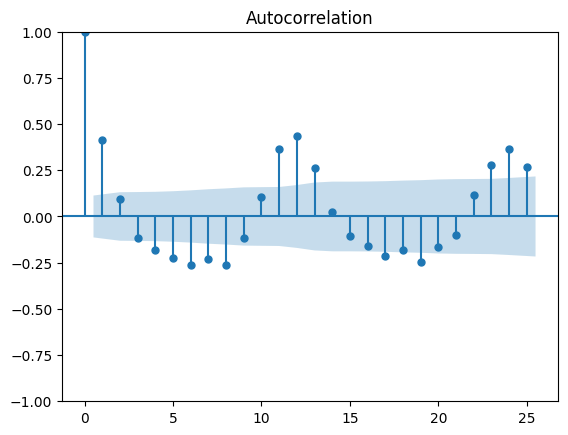

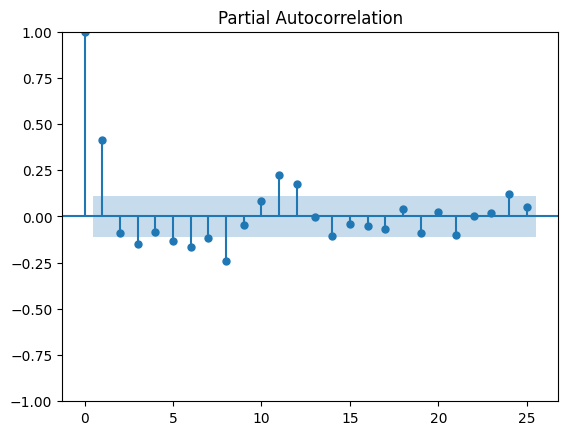

In [9]:
#Plot ACF and PACF to determine order of AR and MA
plot_acf(freq)
plot_pacf(freq)
plt.show()

In [10]:
#80/20 train/test split
train=freq.iloc[:-62]
test=freq.iloc[-62:]
print(train.shape, test.shape)

(237, 1) (62, 1)


In [11]:
#Fit Model and create range for predictions
model = ARIMA(train['Value'], order=(12, 1, 11))
model_fit = model.fit()
start = len(train)  
end = len(train) + len(test) - 1  
pred = model_fit.predict(start=start, end=end, typ='levels')

c:\Users\thabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\thabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\thabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\thabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible startin

np.float64(9845.954768758149)

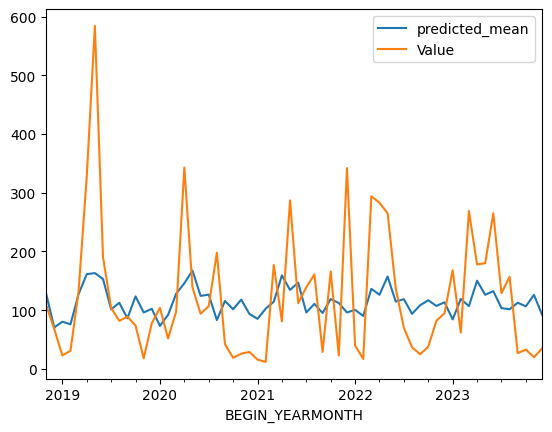

In [12]:
#ARIMA predictions vs actual values. MSE of 9845.95
pred.index = test.index
pred.plot(legend=True)
test['Value'].plot(legend=True)
MSE = mean_squared_error(pred,test['Value'])
MSE

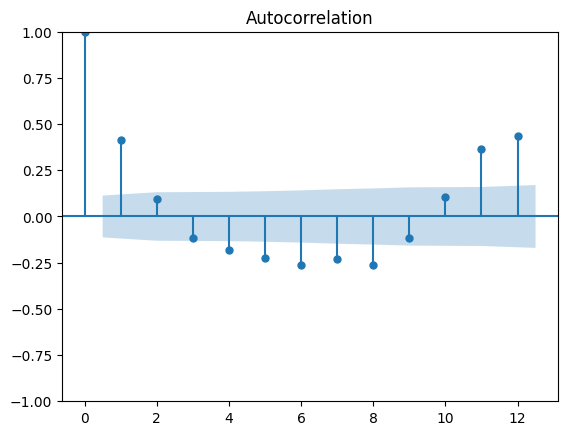

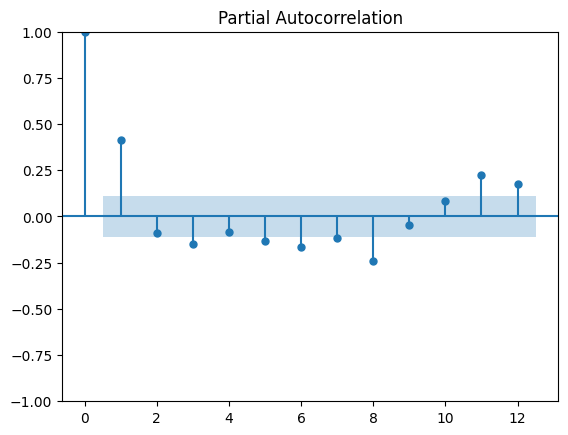

In [13]:
##Plot ACF and PACF to determine order of AR and MA
plot_acf(freq, lags = 12)
plot_pacf(freq, lags = 12)
plt.show()

In [14]:
#Fit Model and create range for predictions, using the same range for train / test
model_sarima = SARIMAX(train['Value'], 
                       order=(1, 0, 1),          
                       seasonal_order=(1, 0, 1, 12))
model_sarima_fit = model_sarima.fit()
start = len(train)  
end = len(train) + len(test) - 1  
pred = model_sarima_fit.predict(start=start, end=end, typ='levels')



c:\Users\thabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\thabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\thabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\thabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

np.float64(7796.830957104562)

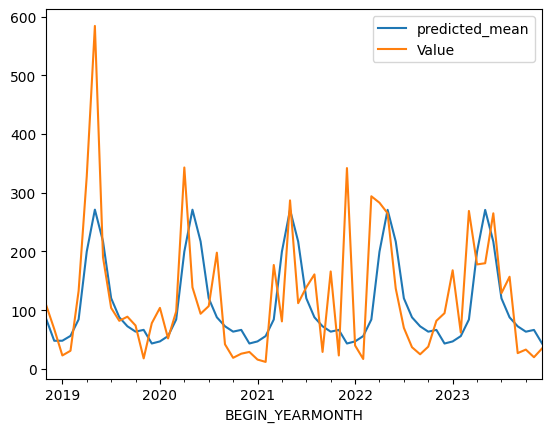

In [15]:
#SARIMA predictions vs actual values. MSE of 7796.83
#Substantially preferred to ARIMA, better at capturing seasonality
pred.index = test.index
pred.plot(legend=True)
test['Value'].plot(legend=True)
MSE = mean_squared_error(pred,test['Value'])
MSE

## ARIMA and SARIMA of Damage of Tornados

In [16]:
combined_df = pd.read_csv('..\\DATA\\combined_data.csv')
combined_df['BEGIN_YEARMONTH'] = pd.to_datetime(combined_df['BEGIN_YEARMONTH'].astype(str), format='%Y%m')
filtered_df = combined_df

def convert_damage_to_millions(value):
    if isinstance(value, str):
        value = value.strip()  
        if value == '': 
            return None  
        if 'M' in value: 
            value = value.replace('M', '').strip()
            if value == '': 
                return None 
            return float(value) * 1_000_000
        elif 'K' in value:
            value = value.replace('K', '').strip()
            if value == '': 
                return None 
            return float(value) * 1_000
        else:
            try:
                return float(value)  
            except ValueError:
                return None 
    elif isinstance(value, (int, float)):
        return value
    else:
        return None  

import pandas as pd

def calculate_tornado_damage(df):
    df['DAMAGE_PROPERTY'] = df['DAMAGE_PROPERTY'].apply(convert_damage_to_millions)
    df['DAMAGE_PROPERTY'] = df['DAMAGE_PROPERTY'].fillna(0)
    
    tornado_damage = df.groupby('BEGIN_YEARMONTH')['DAMAGE_PROPERTY'].sum()
    return tornado_damage

tornado_damage = calculate_tornado_damage(filtered_df)

C:\Users\thabe\AppData\Local\Temp\ipykernel_6940\2470301305.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv('..\\DATA\\combined_data.csv')


In [17]:
damage = pd.DataFrame(tornado_damage)
damage.columns = ['Value']
result = adfuller(damage['Value'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -3.595237901940805
p-value: 0.005852724197390058


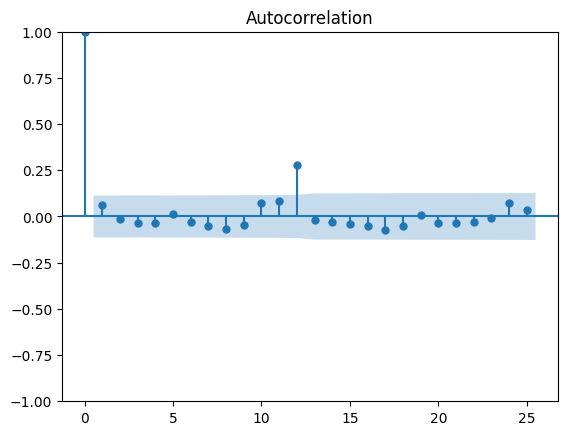

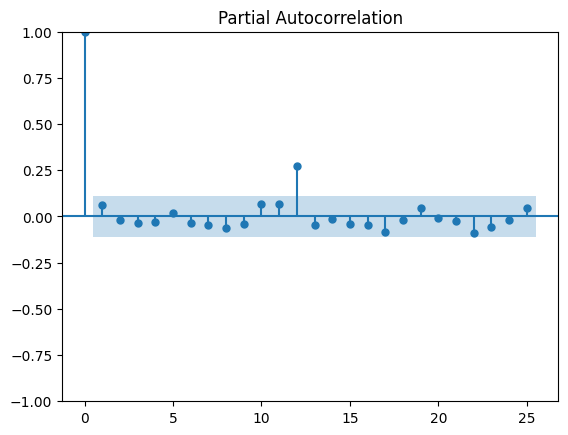

In [19]:
plot_acf(damage)
plot_pacf(damage)
plt.show()

In [20]:
#80/20 train/test split
train=damage.iloc[:-60]
test=damage.iloc[-60:]
print(train, test)
print(train.shape, test.shape)

                        Value
BEGIN_YEARMONTH              
1999-01-01       1.500598e+08
1999-02-01       1.942000e+06
1999-03-01       8.883000e+06
1999-04-01       1.724661e+08
1999-05-01       1.411829e+09
...                       ...
2018-08-01       8.159000e+06
2018-09-01       7.865100e+06
2018-10-01       6.860500e+06
2018-11-01       1.957500e+07
2018-12-01       1.273030e+08

[239 rows x 1 columns]                        Value
BEGIN_YEARMONTH             
2019-01-01         2280000.0
2019-02-01         4405000.0
2019-03-01        22784000.0
2019-04-01       128208000.0
2019-05-01       847925000.0
2019-06-01         9130000.0
2019-07-01        11526500.0
2019-08-01         8935000.0
2019-09-01        19759000.0
2019-10-01       451813000.0
2019-11-01          555000.0
2019-12-01        33177000.0
2020-01-01        23829000.0
2020-02-01        24870000.0
2020-03-01       825300000.0
2020-04-01       478103000.0
2020-05-01         4054000.0
2020-06-01         1833000.0
2020-0

In [42]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train['Value'], order=(12, 0, 12))
model_fit = model.fit()
start = len(train)  
end = len(train) + len(test) - 1  
pred = model_fit.predict(start=start, end=end, typ='levels')

c:\Users\thabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\thabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\thabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\thabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimiza

np.float64(3.8633311590744456e+16)

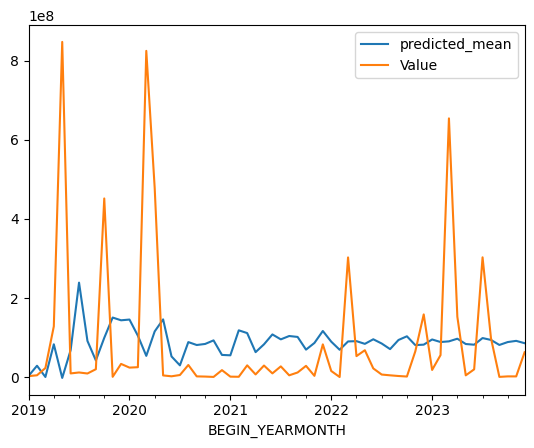

In [43]:
from sklearn.metrics import mean_squared_error

pred.index = test.index
pred.plot(legend=True)
test['Value'].plot(legend=True)
MSE = mean_squared_error(pred,test['Value'])
MSE

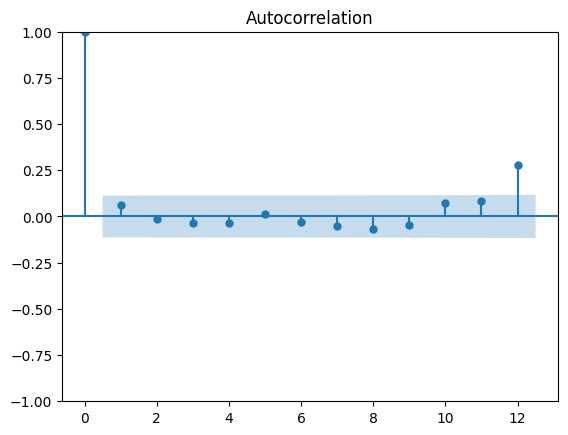

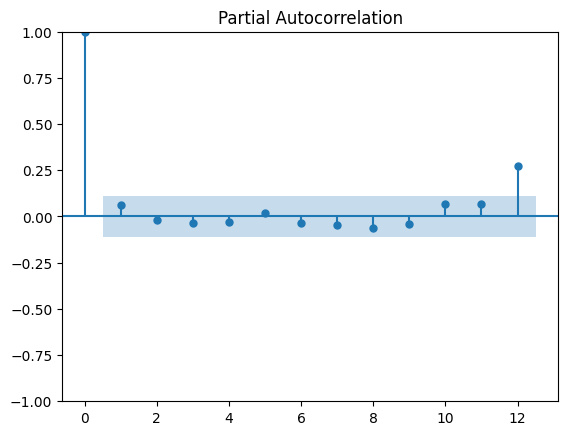

In [23]:
##Plot ACF and PACF to determine order of AR and MA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(damage, lags = 12)
plot_pacf(damage, lags = 12)
plt.show()

In [44]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarima = SARIMAX(train['Value'], 
                       order=(1, 0, 1),          
                       seasonal_order=(1, 0, 1, 12))
model_sarima_fit = model_sarima.fit()
start = len(train)  
end = len(train) + len(test) - 1  
pred = model_sarima_fit.predict(start=start, end=end, typ='levels')



c:\Users\thabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\thabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\thabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\thabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

np.float64(3.613820889582726e+16)

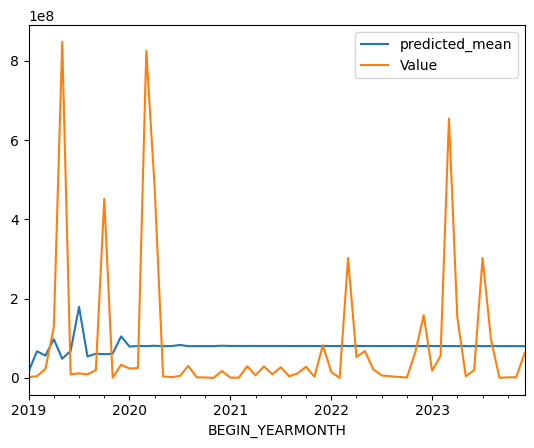

In [45]:
#SARIMA predictions vs actual values. MSE of 8051.06
#Substantially preferred to ARIMA, better at capturing seasonality
pred.index = test.index
pred.plot(legend=True)
test['Value'].plot(legend=True)
MSE = mean_squared_error(pred,test['Value'])
MSE